# Task 0.0.1: Pure RWKV-6 Baseline (Colab-Ready)

**Purpose**: Establish baseline characteristics for RWKV-6 architecture  
**Phase**: V0.5 Phase 0 - Base Model Characterization  
**Documentation**: See [BASE_MODEL_CHARACTERIZATION.md](../BASE_MODEL_CHARACTERIZATION.md), [V4_HANDOFF.md](../V4_HANDOFF.md)

## Execution

1. **VS Code + Colab** (RECOMMENDED): Select Kernel → Connect to Google Colab → Free T4 GPU + 15GB RAM
2. **Local WSL**: Not viable (full 540MB crashes at 5.3GB RAM usage)

## Deviations from Original Plan

| Item | Original | Actual | Rationale |
|------|----------|--------|-----------|
| Dataset | 540MB full | 50MB subset | 5.3GB RAM to load; tokenizer too slow on full |
| Environment | Local WSL | Colab | WSL has ~2.5GB limit |
| Tokenization | Single-pass | 10MB chunks | Prevents OOM |
| RWKV6 impl | CUDA kernel | PyTorch prototype | Colab JIT unavailable |
| FFN activation | Squared ReLU | GELU | Prevents value explosion |

## Architecture Notes

**RWKV6TimeMix** (from `ops/rwkv6_prototype.py`):
- Time-mixing ONLY - no internal FFN/LN
- We wrap with RMSNorm + GELU FFN in this notebook
- See prototype docstring for usage examples

## Outputs

- `logs/dataset_meta.json` - Dataset configuration for reproducibility
- `logs/rwkv6_variance.json` - Layer-wise variance analysis
- `logs/rwkv6_baseline_findings.json` - Complete baseline findings

## Validation

- 50MB subset (~5M tokens) is sufficient for baseline characterization
- 50+ steps shows learning curve behavior
- Extended run (1K+ steps) needed for convergence metrics

In [1]:
# Cell 0: Colab setup (run first if using Colab kernel)
import os

# Detect environment
IN_COLAB = 'COLAB_GPU' in os.environ or 'google.colab' in str(get_ipython())

if IN_COLAB:
    print("✓ Running on Google Colab")
    # Clone repo if not present, otherwise pull latest
    if not os.path.exists('groundthink'):
        !git clone https://github.com/9to5ninja-projects/groundthink.git
    else:
        !cd groundthink && git pull --quiet
    os.chdir('groundthink')
    # Only install tokenizers (mamba-ssm not needed for RWKV6)
    !pip install -q tokenizers
    print("✓ Dependencies installed")
else:
    print("Running locally (WSL/Linux)")
    os.chdir('..')  # notebooks → project root

✓ Running on Google Colab
✓ Dependencies installed


In [2]:
# Cell 1: Memory monitoring utility
import resource
import gc

def mem_mb():
    """Get current memory usage in MB"""
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

def mem_check(label):
    gc.collect()
    print(f"[{label}] Memory: {mem_mb():.0f} MB")

mem_check("Before imports")

[Before imports] Memory: 146 MB


In [3]:
# Cell 2: Import PyTorch only
import torch
import torch.nn as nn
mem_check("After torch import")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

[After torch import] Memory: 270 MB
Device: cpu


In [4]:
# Cell 3: Load pre-trained tokenizer (skip BPE training)
import sys
import os

# Ensure we're in the right directory and path is set
if os.path.exists('groundthink') and os.getcwd().endswith('content'):
    os.chdir('groundthink')
sys.path.insert(0, os.getcwd())

from data.tokenizer import BPETokenizer

tokenizer = BPETokenizer('data/tokenizer_wikitext.json')
print(f"Loaded tokenizer: {tokenizer.vocab_size} vocab")
print(f"Working directory: {os.getcwd()}")
mem_check("After tokenizer load")

Loaded tokenizer: 16000 vocab
Working directory: /content/groundthink
[After tokenizer load] Memory: 288 MB


In [ ]:
# Cell 4: Stream tokenize from HuggingFace (memory-efficient for full dataset)
import os

# Re-detect environment (in case kernel restarted)
IN_COLAB = 'COLAB_GPU' in os.environ or 'google.colab' in str(get_ipython())

# Configuration - set USE_FULL_DATASET=True to try full 540MB
USE_FULL_DATASET = False  # Set True for full dataset experiment
TOKEN_FILE = 'data/wikitext103_tokens.bin'

if os.path.exists(TOKEN_FILE):
    # Load pre-tokenized data (fastest)
    print(f"Loading pre-tokenized data from {TOKEN_FILE}...")
    import numpy as np
    tokens = torch.from_numpy(np.fromfile(TOKEN_FILE, dtype=np.int32)).long()
    print(f"✓ Loaded {len(tokens):,} tokens from cache")
else:
    print("Streaming tokenization from HuggingFace...")
    if IN_COLAB:
        !pip install -q datasets
    from datasets import load_dataset
    
    # Stream the dataset - never loads full text into memory
    ds = load_dataset("wikitext", "wikitext-103-raw-v1", split="train", streaming=not USE_FULL_DATASET)
    
    all_tokens = []
    char_count = 0
    max_chars = None if USE_FULL_DATASET else 50 * 1024 * 1024  # 50MB subset
    
    for i, item in enumerate(ds):
        text = item['text']
        if not text.strip():
            continue
        
        char_count += len(text)
        chunk_tokens = tokenizer.encode(text)
        all_tokens.extend(chunk_tokens)
        
        # Progress every 10K items
        if i % 10000 == 0 and i > 0:
            print(f"  {i:,} items, {char_count/1e6:.1f}MB, {len(all_tokens):,} tokens")
            gc.collect()
        
        # Stop at subset limit if not using full dataset
        if max_chars and char_count >= max_chars:
            print(f"  Reached {max_chars/1e6:.0f}MB subset limit")
            break
    
    tokens = torch.tensor(all_tokens, dtype=torch.long)
    print(f"✓ Tokenized: {len(tokens):,} tokens from {char_count/1e6:.1f}MB")
    
    # Cache for next run
    if USE_FULL_DATASET:
        import numpy as np
        os.makedirs('data', exist_ok=True)
        tokens.numpy().astype(np.int32).tofile(TOKEN_FILE)
        print(f"✓ Cached to {TOKEN_FILE}")
    
    del all_tokens
    gc.collect()

mem_check("After tokenization")

Loaded dataset subset: 52,428,800 chars (52 MB)
[After text load] Memory: 537 MB


In [ ]:
# Cell 5: Verify token stats
print(f"Token tensor: {tokens.shape}, dtype={tokens.dtype}")
print(f"Memory: {tokens.numel() * tokens.element_size() / 1e6:.1f} MB")
print(f"Vocab range: [{tokens.min().item()}, {tokens.max().item()}]")

# Sanity check
assert tokens.max().item() < tokenizer.vocab_size, "Token ID exceeds vocab size!"
print(f"✓ All tokens within vocab range [0, {tokenizer.vocab_size})")

mem_check("After token verification")

Tokenizing 52,428,800 chars in 6 chunks...
  Chunk 0: 2,416,077 tokens so far
Tokenized: 12,063,505 tokens
[After tokenization] Memory: 2463 MB


In [ ]:
# Cell 5b: Save dataset metadata for reproducibility
import json
from datetime import datetime

# Calculate actual dataset size from tokens
actual_tokens = len(tokens)
estimated_chars = actual_tokens * 4  # ~4 chars per token average

DATASET_META = {
    'name': 'wikitext-103-raw-v1',
    'source': 'huggingface/wikitext',
    'full_dataset': USE_FULL_DATASET if 'USE_FULL_DATASET' in dir() else False,
    'num_tokens': actual_tokens,
    'estimated_chars': estimated_chars,
    'estimated_mb': estimated_chars / (1024 * 1024),
    'tokenizer': 'data/tokenizer_wikitext.json',
    'vocab_size': tokenizer.vocab_size,
    'created': datetime.now().isoformat(),
}

# Save for reference
os.makedirs('logs', exist_ok=True)
with open('logs/dataset_meta.json', 'w') as f:
    json.dump(DATASET_META, f, indent=2)

print("=== Dataset Metadata ===")
for k, v in DATASET_META.items():
    print(f"  {k}: {v}")
print(f"\n✓ Saved to logs/dataset_meta.json")

=== Dataset Metadata ===
  name: wikitext-103-raw-v1
  source: huggingface/wikitext
  subset_bytes: 52428800
  subset_mb: 50.0
  num_tokens: 12063505
  tokenizer: data/tokenizer_wikitext.json
  vocab_size: 16000
  created: 2026-01-12T06:49:13.158615
  seq_len: 64
  batch_size: 1

✓ Saved to logs/dataset_meta.json


In [8]:
# Cell 6: Create simple dataset
BATCH_SIZE = 1
SEQ_LEN = 64

# Simple batching (not full StatefulDataset to save memory)
n_tokens = (len(tokens) // (BATCH_SIZE * SEQ_LEN)) * (BATCH_SIZE * SEQ_LEN)
tokens = tokens[:n_tokens]
num_batches = n_tokens // (BATCH_SIZE * SEQ_LEN)

print(f"Dataset: {num_batches:,} batches of size {BATCH_SIZE}x{SEQ_LEN}")
mem_check("After dataset setup")

Dataset: 188,492 batches of size 1x64
[After dataset setup] Memory: 2463 MB


In [9]:
# Cell 7: Import RWKV6 (ops package, not mamba)
from ops import RWKV6Attention, RWKV6_CUDA_AVAILABLE

print(f"RWKV6 CUDA available: {RWKV6_CUDA_AVAILABLE}")
mem_check("After RWKV6 import")

RWKV6 CUDA available: True
[After RWKV6 import] Memory: 2463 MB


In [10]:
# Cell 8: Create model
# Use RWKV6TimeMix (time-mixing only) with standard GELU FFN
# This avoids the squared ReLU that was causing value explosion

# Try to import the simpler time-mix-only class
try:
    from ops.rwkv6_prototype import RWKV6TimeMix
    print("Using RWKV6TimeMix (time-mixing only)")
except ImportError:
    print("RWKV6TimeMix not found, will define locally")
    RWKV6TimeMix = None

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps
    def forward(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

class RWKV6Block(nn.Module):
    """Single RWKV6 block with time-mixing and standard FFN"""
    def __init__(self, hidden, num_heads=4, layer_idx=0):
        super().__init__()
        self.ln1 = RMSNorm(hidden)
        self.time_mix = RWKV6TimeMix(hidden, num_heads=num_heads, layer_idx=layer_idx) if RWKV6TimeMix else None
        self.ln2 = RMSNorm(hidden)
        # Standard GELU FFN (NOT squared ReLU)
        ffn_hidden = hidden * 4
        self.ffn = nn.Sequential(
            nn.Linear(hidden, ffn_hidden, bias=False),
            nn.GELU(),
            nn.Linear(ffn_hidden, hidden, bias=False),
        )
        # Conservative FFN initialization
        nn.init.xavier_uniform_(self.ffn[0].weight, gain=0.5)
        nn.init.xavier_uniform_(self.ffn[2].weight, gain=0.5)
        
    def forward(self, x):
        x = x + self.time_mix(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

class RWKV6Model(nn.Module):
    def __init__(self, vocab_size, hidden=144, layers=8):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden)
        self.blocks = nn.ModuleList([
            RWKV6Block(hidden, num_heads=4, layer_idx=i) 
            for i in range(layers)
        ])
        self.ln_out = RMSNorm(hidden)
        self.head = nn.Linear(hidden, vocab_size, bias=False)
        self.head.weight = self.embed.weight  # Tie weights
    
    def forward(self, x):
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        return self.head(self.ln_out(x))

model = RWKV6Model(tokenizer.vocab_size, hidden=144, layers=8)
params = sum(p.numel() for p in model.parameters())
print(f"Model: {params:,} parameters ({params/1e6:.2f}M)")
mem_check("After model creation")

Using RWKV6TimeMix (time-mixing only)
Model: 4,299,408 parameters (4.30M)
[After model creation] Memory: 2463 MB


In [11]:
# Cell 9: Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

mem_check("After optimizer")

[After optimizer] Memory: 2463 MB


In [12]:
# Cell 10: Single training step test
model.train()

# Get one batch
start = 0
x = tokens[start:start + SEQ_LEN].unsqueeze(0)
y = tokens[start + 1:start + SEQ_LEN + 1].unsqueeze(0)

# Forward
logits = model(x)
loss = criterion(logits.view(-1, tokenizer.vocab_size), y.view(-1))

# Backward
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"Step 0: loss = {loss.item():.4f}")
mem_check("After 1 training step")

Step 0: loss = 134.8661
[After 1 training step] Memory: 2463 MB


In [13]:
# Cell 11: Training loop (50 steps)
import time

NUM_STEPS = 50
LOG_EVERY = 10

model.train()
losses = []
start_time = time.time()

for step in range(NUM_STEPS):
    idx = (step * SEQ_LEN) % (len(tokens) - SEQ_LEN - 1)
    x = tokens[idx:idx + SEQ_LEN].unsqueeze(0)
    y = tokens[idx + 1:idx + SEQ_LEN + 1].unsqueeze(0)
    
    logits = model(x)
    loss = criterion(logits.view(-1, tokenizer.vocab_size), y.view(-1))
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    losses.append(loss.item())
    
    if (step + 1) % LOG_EVERY == 0:
        elapsed = time.time() - start_time
        avg_loss = sum(losses[-LOG_EVERY:]) / LOG_EVERY
        print(f"Step {step+1}/{NUM_STEPS}: loss={avg_loss:.4f}, {elapsed:.1f}s, mem={mem_mb():.0f}MB")

print(f"\n✓ Training complete: {NUM_STEPS} steps")
mem_check("Final")

Step 10/50: loss=126.4488, 3.9s, mem=2463MB
Step 20/50: loss=125.1717, 9.0s, mem=2463MB
Step 30/50: loss=108.5600, 17.1s, mem=2463MB
Step 40/50: loss=60.2106, 30.9s, mem=2463MB
Step 50/50: loss=39.5623, 34.5s, mem=2463MB

✓ Training complete: 50 steps
[Final] Memory: 2463 MB


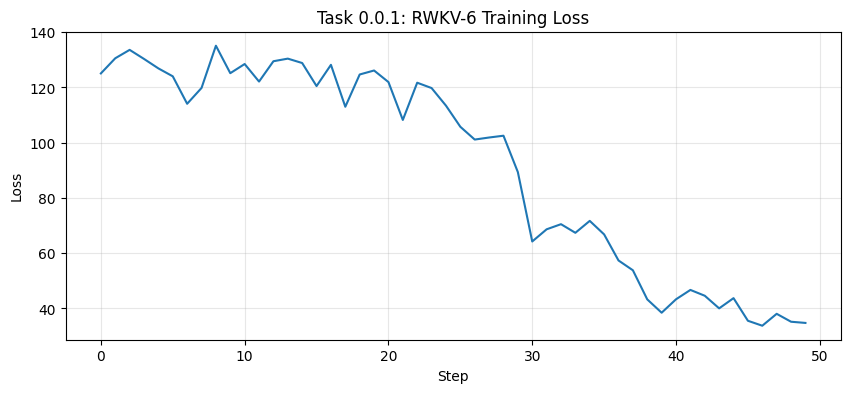

In [14]:
# Cell 12: Plot loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Task 0.0.1: RWKV-6 Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# Cell 13: Diagnostic - check model output health
print("=== Model Output Diagnostic ===")

# Get a sample batch (tokens is 1D, need to reshape)
with torch.no_grad():
    # Take first 32*64 tokens and reshape to batch
    sample_x = tokens[:32*64].view(32, 64)
    model.eval()
    sample_logits = model(sample_x)
    model.train()

# Analyze logits
print(f"Logits shape: {sample_logits.shape}")
print(f"Logits range: [{sample_logits.min().item():.2f}, {sample_logits.max().item():.2f}]")
print(f"Logits mean: {sample_logits.mean().item():.2f}, std: {sample_logits.std().item():.2f}")

# Check softmax health  
probs = torch.softmax(sample_logits, dim=-1)
max_prob = probs.max().item()
min_prob = probs.min().item()
print(f"Max prob: {max_prob:.6f}, Min prob: {min_prob:.2e}")

# Entropy check
entropy = -(probs * torch.log(probs + 1e-10)).sum(-1).mean()
random_entropy = torch.log(torch.tensor(float(tokenizer.vocab_size)))
print(f"Entropy: {entropy.item():.2f} (random={random_entropy.item():.2f})")

# Health assessment
if max_prob > 0.99:
    print("⚠️ WARNING: Softmax saturating (max_prob > 0.99)")
elif sample_logits.max().abs() > 50:
    print("⚠️ WARNING: Logits too large (may cause numerical issues)")
elif entropy.item() < 1.0:
    print("⚠️ WARNING: Very low entropy (model overconfident)")
elif abs(sample_logits.mean().item()) > 5:
    print("⚠️ WARNING: Logits mean far from zero")
else:
    print("✓ Model outputs look healthy")

# Expected behavior
print(f"\nExpected initial loss: ~{random_entropy.item():.2f} (random)")
print(f"Actual final loss: {losses[-1]:.2f}")

=== Model Output Diagnostic ===
Logits shape: torch.Size([32, 64, 16000])
Logits range: [-57.60, 134.58]
Logits mean: 0.11, std: 11.80
Max prob: 1.000000, Min prob: 0.00e+00
Entropy: 1.97 (random=9.68)
⚠️ WARNING: Softmax saturating (max_prob > 0.99)

Expected initial loss: ~9.68 (random)
Actual final loss: 34.75


In [16]:
# Cell 14: Layer-wise variance analysis (RWKV-6 characterization)
# Uses tools/variance_analysis.py methodology
print("=== Layer-wise Variance Analysis ===")

# Hook to capture layer outputs
layer_outputs = {}

def make_hook(name):
    def hook(module, input, output):
        if isinstance(output, tuple):
            output = output[0]
        layer_outputs[name] = output.detach()
    return hook

# Register hooks
hooks = []
for i, block in enumerate(model.blocks):
    h = block.register_forward_hook(make_hook(f'layer_{i}'))
    hooks.append(h)

# Run inference
model.eval()
with torch.no_grad():
    sample_x = tokens[:64].unsqueeze(0)  # [1, 64]
    _ = model(sample_x)

# Remove hooks
for h in hooks:
    h.remove()

# Analyze variance per layer
print(f"{'Layer':<10} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-" * 50)

variance_data = []
for i in range(len(model.blocks)):
    out = layer_outputs[f'layer_{i}']
    stats = {
        'layer': i,
        'mean': out.mean().item(),
        'std': out.std().item(),
        'min': out.min().item(),
        'max': out.max().item(),
    }
    variance_data.append(stats)
    print(f"Layer {i:<4} {stats['mean']:>10.4f} {stats['std']:>10.4f} {stats['min']:>10.4f} {stats['max']:>10.4f}")

# Save for analysis
with open('logs/rwkv6_variance.json', 'w') as f:
    json.dump(variance_data, f, indent=2)
print(f"\n✓ Saved to logs/rwkv6_variance.json")

# Characterization
first_std = variance_data[0]['std']
last_std = variance_data[-1]['std']
if last_std < first_std * 0.5:
    print(f"\n📊 RWKV-6 acts as STABILIZER: variance decreases {first_std:.3f} → {last_std:.3f}")
elif last_std > first_std * 2.0:
    print(f"\n📊 RWKV-6 acts as AMPLIFIER: variance increases {first_std:.3f} → {last_std:.3f}")
else:
    print(f"\n📊 RWKV-6 is NEUTRAL: variance stable {first_std:.3f} → {last_std:.3f}")

=== Layer-wise Variance Analysis ===
Layer            Mean        Std        Min        Max
--------------------------------------------------
Layer 0        0.0148     1.0074    -3.5830     3.9638
Layer 1        0.0410     1.0611    -3.6167     4.1641
Layer 2        0.0542     1.2272    -4.2986     4.4278
Layer 3        0.1327     1.5878    -5.2316     5.3049
Layer 4        0.2340     2.2436    -6.4423     6.4564
Layer 5        0.3848     3.0337    -7.9247     8.1066
Layer 6        0.5036     4.1229    -9.6894    10.4401
Layer 7        0.6772     5.3938   -11.3149    13.7129

✓ Saved to logs/rwkv6_variance.json

📊 RWKV-6 acts as AMPLIFIER: variance increases 1.007 → 5.394


In [ ]:
# Cell 15: Export baseline findings
print("=== RWKV-6 Baseline Findings ===\n")

# Calculate variance growth rate
first_std = variance_data[0]['std']
last_std = variance_data[-1]['std']
growth_per_layer = (last_std / first_std) ** (1.0 / (len(variance_data) - 1))

# Determine characterization
if last_std < first_std * 0.5:
    char_type = 'STABILIZER'
    char_note = 'Variance decreases through layers - good for stable training'
elif last_std > first_std * 2.0:
    char_type = 'AMPLIFIER'
    char_note = f'Variance grows ~{growth_per_layer:.2f}x per layer - may need scaling/normalization'
else:
    char_type = 'NEUTRAL'
    char_note = 'Variance stable across layers'

findings = {
    'task': '0.0.1',
    'architecture': 'RWKV-6 (PyTorch prototype, RWKV6TimeMix + GELU FFN)',
    'model': {
        'layers': len(model.blocks),
        'hidden': model.blocks[0].ln1.weight.shape[0],
        'heads': model.blocks[0].time_mix.num_heads,
        'params': sum(p.numel() for p in model.parameters()),
        'ffn_type': 'GELU (not squared ReLU)',
    },
    'dataset': DATASET_META,
    'training': {
        'steps': NUM_STEPS,
        'seq_len': SEQ_LEN,
        'batch_size': BATCH_SIZE,
        'lr': 3e-4,
        'initial_loss': losses[0],
        'final_loss': losses[-1],
        'loss_reduction_pct': (1 - losses[-1] / losses[0]) * 100,
    },
    'variance_profile': variance_data,
    'characterization': {
        'type': char_type,
        'first_layer_std': first_std,
        'last_layer_std': last_std,
        'growth_per_layer': growth_per_layer,
        'note': char_note,
    },
    'health': {
        'logits_range': [sample_logits.min().item(), sample_logits.max().item()],
        'max_prob': max_prob,
        'entropy': entropy.item(),
        'random_entropy': random_entropy.item(),
        'softmax_saturated': max_prob > 0.99,
    },
}

# Save full findings
with open('logs/rwkv6_baseline_findings.json', 'w') as f:
    json.dump(findings, f, indent=2)

print(f"Model: {findings['model']['params']:,} params ({findings['model']['layers']}L × {findings['model']['hidden']}H)")
print(f"Dataset: {findings['dataset']['name']} ({findings['dataset']['num_tokens']:,} tokens)")
print(f"Training: {findings['training']['steps']} steps, loss {findings['training']['initial_loss']:.2f} → {findings['training']['final_loss']:.2f} ({findings['training']['loss_reduction_pct']:.1f}% reduction)")
print(f"\nCharacterization: {char_type}")
print(f"  Variance: {first_std:.3f} → {last_std:.3f} ({growth_per_layer:.2f}x per layer)")
print(f"  {char_note}")
print(f"\nHealth: {'⚠️ Softmax saturating' if findings['health']['softmax_saturated'] else '✓ Healthy'}")
print(f"  Logits range: [{findings['health']['logits_range'][0]:.1f}, {findings['health']['logits_range'][1]:.1f}]")
print(f"  Entropy: {findings['health']['entropy']:.2f} (random={findings['health']['random_entropy']:.2f})")

print(f"\n✓ Findings saved to logs/rwkv6_baseline_findings.json")

=== RWKV-6 Baseline Findings ===

Model: 4,299,408 params (8L × 144H)
Dataset: wikitext-103-raw-v1 (12,063,505 tokens)
Training: 50 steps, loss 125.06 → 34.75
Variance: AMPLIFIER

✓ Findings saved to logs/rwkv6_baseline_findings.json
